### Imports

In [120]:
# Standard library
import sqlite3
import os

# Third-party
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Local application
from kickbase_api.player_data import (
    get_all_players,
    get_player_id,
    get_player_info,
    get_player_market_value,
    get_player_performance,
    get_player_events,
)
from kickbase_api.user_management import login

### Login to Kickbase

In [121]:
# Load environment variables from .env file
load_dotenv() 
USERNAME = os.getenv("KICK_USER")
PASSWORD = os.getenv("KICK_PASS")

# Login and get token
token = login(USERNAME, PASSWORD)
print("Logged in.")

Logged in.


### Connect to SQLite Database

In [122]:
conn = sqlite3.connect("bundesliga.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS player_data (
    player_id INTEGER,
    team_id INTEGER,
    team_name TEXT,
    first_name TEXT,
    last_name TEXT,
    position TEXT,
    md DATE,
    p REAL,
    mp INTEGER,
    ppm REAL,
    t1 INTEGER,
    t2 INTEGER,
    t1g INTEGER,
    t2g INTEGER,
    won INTEGER,
    k TEXT,
    mv REAL
);
""")

conn.commit()

### Get Player Data from Kickbase and Store in Database

In [123]:
competition_ids = [1, 2]  # 1 = Bundesliga, 2 = 2. Bundesliga (for more training data)
last_mv_values = 365  # in days, max 365
last_pfm_values = 50  # in matchdays
reload_data = False

if reload_data:
    all_competitions_dfs = []

    for competition_id in competition_ids:
        players = get_all_players(token, competition_id)

        def process_player(player_id):
            player_info = get_player_info(token, competition_id, player_id)
            player_team_id = player_info["team_id"]
            player_df = pd.DataFrame([player_info])

            market_value = get_player_market_value(token, competition_id, player_id, last_mv_values)
            mv_df = pd.DataFrame(market_value)

            performance = get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id)
            p_df = pd.DataFrame(performance)

            if p_df.empty:
                p_df = pd.DataFrame(columns=["md"])

            if mv_df.empty:
                mv_df = pd.DataFrame(columns=["md"])

            merged_df = pd.merge(p_df, mv_df, on="md", how="inner")
            merged_df = player_df.merge(merged_df, how="cross")

            # Add competition_id column
            merged_df["competition_id"] = competition_id

            return merged_df

        comp_dfs = list(map(process_player, players))
        comp_final_df = pd.concat(comp_dfs, ignore_index=True)
        all_competitions_dfs.append(comp_final_df)

    # Merge all competitions together
    final_df = pd.concat(all_competitions_dfs, ignore_index=True)

    # Convert list to string in 'k' column
    final_df["k"] = final_df["k"].apply(lambda x: ",".join(map(str, x)) if isinstance(x, list) else None if x is None else str(x))

    # Save to sqlite
    conn = sqlite3.connect("bundesliga.db")
    final_df.to_sql("player_data", conn, if_exists="replace", index=False)
    conn.close()

In [124]:
conn = sqlite3.connect("bundesliga.db")
df = pd.read_sql("SELECT * FROM player_data", conn)
conn.close()

### Preprocess Data

In [125]:
# 1. Sort and filter
df = df.sort_values(["player_id", "md"])
df = df[(df["team_id"] == df["t1"]) | (df["team_id"] == df["t2"])]  # keep only t1 or t2

# 2. Date and matchday calculations 
df["md"] = pd.to_datetime(df["md"])
df["next_md"] = df.groupby("player_id")["md"].shift(-1)
df["days_to_next"] = (df["next_md"] - df["md"]).dt.days

# 3. Opponent and next week values
df["opponent"] = np.where(df["team_id"] == df["t1"], df["t2"], df["t1"])
df["mv_next_week"] = df.groupby("player_id")["mv"].shift(-1)
df["opponent_next_week"] = df.groupby("player_id")["opponent"].shift(-1)

# Only keep rows where next match is within 14 days
mask = df["days_to_next"] <= 14
df.loc[~mask, ["mv_next_week", "opponent_next_week"]] = None

# 4. Market value calculations
df["mv_change"] = df["mv_next_week"] - df["mv"]
df = df.dropna(subset=["mv_next_week", "mv_change"])
df = df[df["mv"] != 0.0]

# 5. Fill missing values
fill_values = {
    "p": 0,
    "ppm": 0,
    "won": -1
}
df = df.fillna(value=fill_values)  # assign back to df to avoid chained assignment

# 6. Feature engineering 
# Market value trend
df["mv_trend"] = df.groupby("player_id")["mv"].pct_change()
df["mv_trend"] = df["mv_trend"].replace([np.inf, -np.inf], 0).fillna(0)
df['mv_acceleration'] = df.groupby('player_id')['mv_trend'].diff()  # 2nd derivative

# Form in last 3 games
df["recent_form"] = df.groupby("player_id")["p"].rolling(3).mean().reset_index(0, drop=True)
df["recent_form"] = df["recent_form"].fillna(df["p"])  # assign back to avoid inplace
df['form_trend'] = df.groupby('player_id')['recent_form'].diff()

# Minutes played consistency (std of last 5 games)
df["mp_consistency"] = df.groupby("player_id")["mp"].rolling(5).std().reset_index(0, drop=True)
df["mp_consistency"] = df["mp_consistency"].fillna(df["mp"].std())  # assign back

# Market value percentile within team & matchday
df["mv_percentile"] = df.groupby(["md", "team_id"])["mv"].rank(pct=True)

# Matchday number per player
df["md_number"] = df.groupby("player_id").cumcount() + 1

# League-wide market context
df["market_momentum"] = df.groupby('md')['mv_change'].transform('mean')  # League-wide momentum
df['relative_to_market'] = df['mv_trend'] - df['market_momentum']
df['market_divergence'] = (df['mv'] / df.groupby('md')['mv'].transform('mean')).rolling(3).mean()

# Clip outliers in mv_change
Q1 = df["mv_change"].quantile(0.25)
Q3 = df["mv_change"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df["mv_change_clipped"] = df["mv_change"].clip(lower_bound, upper_bound)


### Select Features and Target Variable

In [126]:
features = [
    "team_id", "position", "p", "mp", "ppm", "mv", "mv_trend", 
    "recent_form", "mp_consistency", "mv_percentile", "market_momentum",
    "mv_acceleration", "form_trend", "relative_to_market", 
    "market_divergence",
]

target = "mv_change_clipped" # or "mv_change"

# Split by time, to avoid data leakage
train = df[df["md"] < "2025-01-01"]
test = df[df["md"] >= "2025-01-01"]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Train Machine Learning Model

In [127]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
signs_correct = np.sum(np.sign(y_test) == np.sign(y_pred))

print(f"Sign accuracy: {np.round((signs_correct / len(y_test)) * 100, 2)}%")
print(f"RMSE: {np.round(rmse, 2)}")
print(f"MAE: {np.round(mae, 2)}")
print(f"R²: {np.round(r2, 3)}")

Sign accuracy: 55.62%
RMSE: 208189629555.43
MAE: 296833.03
R²: 0.492


### Example Player Prediction

,player_id,first_name,last_name,md,mv,mv_next_week,mv_change,mv_change_clipped,predicted_mv_change,predicted_mv_next_week
3264,2988,Jamie,Leweling,2025-01-12,17757360.0,18036495.0,279135.0,279135.0,-32336.12,17725023.88
3265,2988,Jamie,Leweling,2025-01-15,18036495.0,18306712.0,270217.0,270217.0,-113677.33,17922817.67
3266,2988,Jamie,Leweling,2025-01-18,18306712.0,19285905.0,979193.0,979193.0,372042.33,18678754.33
3267,2988,Jamie,Leweling,2025-01-25,19285905.0,19946740.0,660835.0,660835.0,-446975.73,18838929.27
3268,2988,Jamie,Leweling,2025-02-01,19946740.0,20215870.0,269130.0,269130.0,-294660.46,19652079.54
3269,2988,Jamie,Leweling,2025-02-08,20215870.0,20602318.0,386448.0,386448.0,233392.76,20449262.76
3270,2988,Jamie,Leweling,2025-02-15,20602318.0,20896289.0,293971.0,293971.0,-172970.61,20429347.39
3271,2988,Jamie,Leweling,2025-02-23,20896289.0,20923776.0,27487.0,27487.0,-157030.72,20739258.28
3272,2988,Jamie,Leweling,2025-02-28,20923776.0,21039900.0,116124.0,116124.0,-358335.19,20565440.81
3273,2988,Jamie,Leweling,2025-03-08,21039900.0,21751012.0,711112.0,711112.0,371605.39,21411505.39


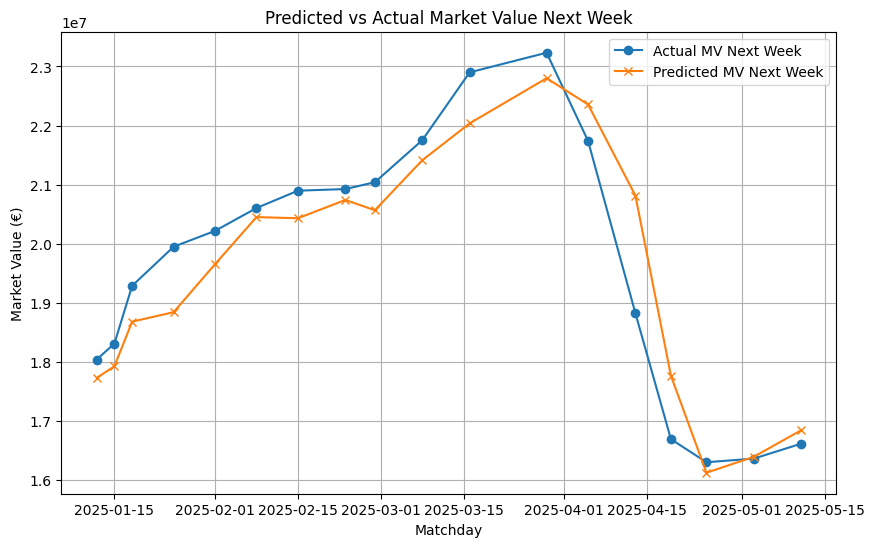

In [137]:
small_test = test[["player_id", "first_name", "last_name", "md", "mv", "mv_next_week", "mv_change", "mv_change_clipped"]].copy()

small_test["predicted_mv_change"] = np.round(y_pred, 2)
small_test["predicted_mv_next_week"] = small_test["mv"] + small_test["predicted_mv_change"]

small_test = small_test.sort_values("md")

small_test = small_test[(small_test["last_name"] == "Leweling")]


display(small_test)

# Plot predicted vs actual mv_next_week
plt.figure(figsize=(10, 6))
plt.plot(small_test["md"], small_test["mv_next_week"], marker='o', label="Actual MV Next Week")
plt.plot(small_test["md"], small_test["predicted_mv_next_week"], marker='x', label="Predicted MV Next Week")
plt.xlabel("Matchday")
plt.ylabel("Market Value (€)")
plt.title("Predicted vs Actual Market Value Next Week")
plt.legend()
plt.grid(True)


### Feature Importance

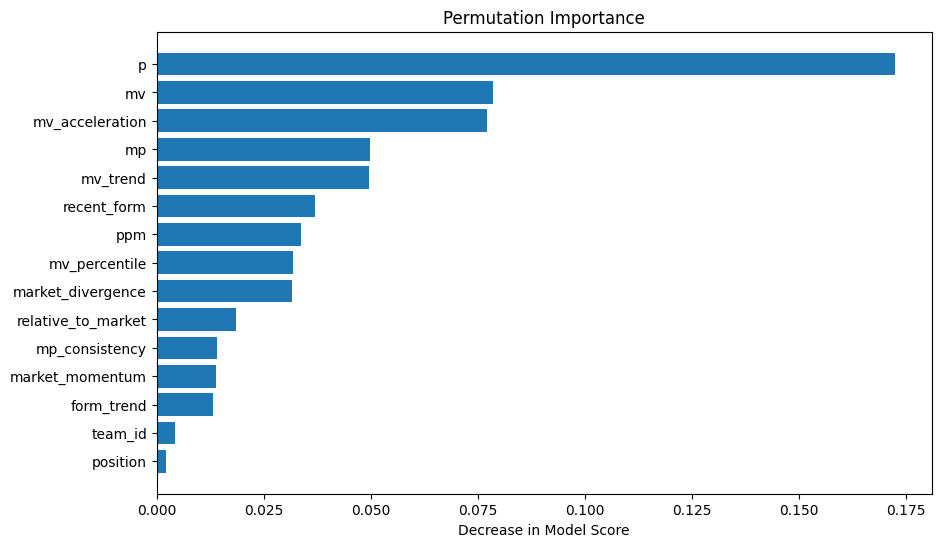

In [129]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'feature': features,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(perm_df['feature'], perm_df['importance'])
plt.gca().invert_yaxis()
plt.title("Permutation Importance")
plt.xlabel("Decrease in Model Score")
plt.show()

### Predicted vs Actual Values

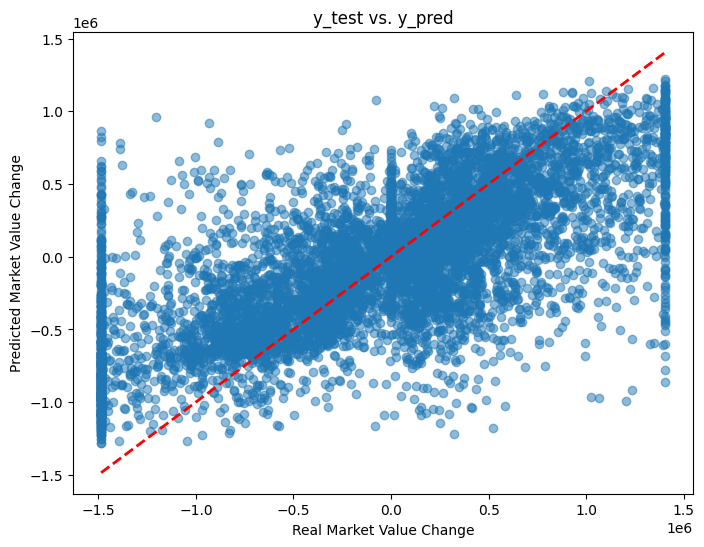

In [130]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Real Market Value Change")
plt.ylabel("Predicted Market Value Change")
plt.title("y_test vs. y_pred")
plt.show()

### Live Data Prediction

In [138]:
display(df)

,player_id,team_id,team_name,first_name,last_name,position,md,p,mp,ppm,...,mv_acceleration,recent_form,form_trend,mp_consistency,mv_percentile,md_number,market_momentum,relative_to_market,market_divergence,mv_change_clipped
23406,10002,48,Magdeburg,Alexander,Ahl-Holmström,4,2025-01-19,0.0,0.0,0.000000,...,NaN,0.000000,NaN,42.782868,0.636364,1,112813.060606,-112813.060606,NaN,-646606.0
23407,10002,48,Magdeburg,Alexander,Ahl-Holmström,4,2025-01-24,0.0,0.0,0.000000,...,-0.177302,0.000000,0.000000,42.782868,0.636364,2,104251.336842,-104251.514144,NaN,-736851.0
23408,10002,48,Magdeburg,Alexander,Ahl-Holmström,4,2025-02-01,0.0,0.0,0.000000,...,-0.068289,0.000000,0.000000,42.782868,0.619048,3,3492.503356,-3492.748947,0.545183,-283257.0
23409,10002,48,Magdeburg,Alexander,Ahl-Holmström,4,2025-02-08,-2.0,53.0,-0.037736,...,0.120448,-0.666667,-0.666667,42.782868,0.571429,4,-12204.501466,12204.376323,0.401054,-199212.0
23410,10002,48,Magdeburg,Alexander,Ahl-Holmström,4,2025-02-14,56.0,58.0,0.965517,...,0.024542,18.000000,18.666667,30.449959,0.571429,5,-23597.528302,23597.427700,0.282605,322461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,9995,14,Hoffenheim,David,Mokwa,4,2025-04-12,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.263158,9,-183320.405844,183320.405844,0.073091,0.0
1954,9995,14,Hoffenheim,David,Mokwa,4,2025-04-19,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.263158,10,-145541.451411,145541.451411,0.075324,0.0
1955,9995,14,Hoffenheim,David,Mokwa,4,2025-04-26,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.315789,11,-227301.393939,227301.393939,0.073861,0.0
1956,9995,14,Hoffenheim,David,Mokwa,4,2025-05-03,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.289474,12,-168599.536765,168599.536765,0.075475,0.0


### Testinggg

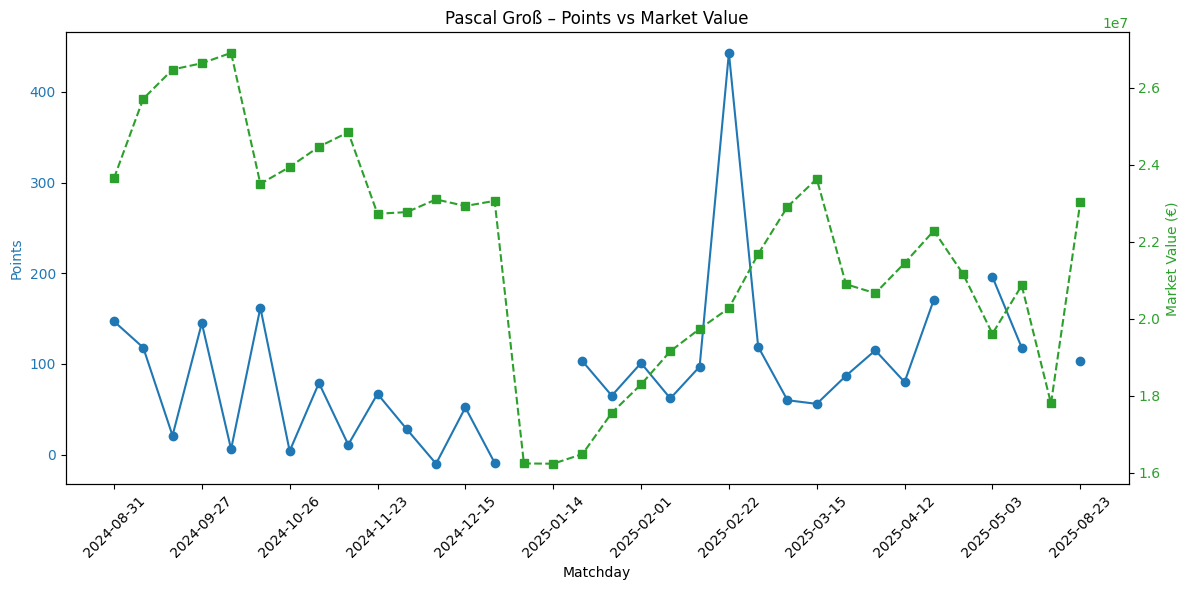

In [131]:
# we need competition_id, player_id, timeframe
competition_id = 1 # 1 is for Bundesliga, info from github issue thread
last_mv_values = 365 # in days, max 365
last_pfm_values = 50 # in matchdays
player_name = "Pascal Groß" # Example player

# Get player ID
player_id = get_player_id(token, competition_id, player_name)

# Get player info
player_info = get_player_info(token, competition_id, player_id)
player_team_id = player_info["team_id"]
player_df = pd.DataFrame([player_info])

# Get player market value
market_value = get_player_market_value(token, competition_id, player_id, last_mv_values)
mv_df = pd.DataFrame(market_value)

# Get player performance
performance = get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id)
p_df = pd.DataFrame(performance)

# Merge on 'md'
merged_df = pd.merge(p_df, mv_df, on="md", how="inner")
merged_df = player_df.merge(merged_df, how="cross")

#display(merged_df)

# Ensure correct column names (adjust if needed)
points_col = "p"          # from performance
mv_col = "mv"         # from market value
matchday_col = "md"            # common key

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Points (left y-axis)
color = "tab:blue"
ax1.set_xlabel("Matchday")
ax1.set_ylabel("Points", color=color)
ax1.plot(merged_df[matchday_col], merged_df[points_col], 
         marker="o", linestyle="-", color=color, label="Points")
ax1.tick_params(axis="y", labelcolor=color)

# X-axis formatting
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=15))  # max ~15 ticks
plt.xticks(rotation=45)

# Create second axis for Market Value (right y-axis)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Market Value (€)", color=color)
ax2.plot(merged_df[matchday_col], merged_df[mv_col], 
         marker="s", linestyle="--", color=color, label="Market Value")
ax2.tick_params(axis="y", labelcolor=color)

# Title and layout
plt.title(f"{player_name} – Points vs Market Value")
fig.tight_layout()
plt.show()